In [1195]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import datetime
import itertools
import matplotlib.pyplot as plt
from functools import reduce
import warnings
import statsmodels.api as sm
import seaborn as sns

from statsmodels.tsa.seasonal import *
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error as MSE
from math import sqrt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

warnings.filterwarnings('ignore')

data source: https://www.bokniseck.de/data

In [1196]:
!pip install -q gdown httpimport
!gdown 'https://github.com/wenjie-hoo/baltic_ml/raw/main/2022.11.07-merged-single-observation.zip'

Downloading...
From: https://github.com/wenjie-hoo/baltic_ml/raw/main/2022.11.07-merged-single-observation.zip
To: /Users/clarkhu/Desktop/DM/project/2022.11.07-merged-single-observation.zip
100%|████████████████████████████████████████| 329k/329k [00:00<00:00, 3.23MB/s]


In [1197]:
# load data to data frame
zip_file = ZipFile('./2022.11.07-merged-single-observation.zip')
dfs = {text_file.filename: pd.read_csv(zip_file.open(text_file.filename))
       for text_file in zip_file.infolist()
       if text_file.filename.endswith('.csv') and not text_file.filename[37:].startswith('.')}

df_list=[]
for df in dfs.values():
       df['DATE'] = pd.to_datetime(df['DATE'],dayfirst = True)
       df_list.append(df)

df = reduce(lambda left,right: pd.merge(left.drop_duplicates(subset=['DATE','DEPTH']),right.drop_duplicates(subset=['DATE','DEPTH']),on=['DATE','DEPTH'],how='outer'), df_list)

In [1198]:
df.head()

,DATE,DEPTH,CHLORA,CTDSAL,CTDTMP,NH4,NO2,NO3,OXY,PH,PO4,SECCHI,SIO2,TN,TP
0,1960-03-31,500,2.90000000,17.90000000,2.20000000,NaN,NaN,NaN,515.60000000,NaN,0.03000000,NaN,NaN,NaN,0.68000000
1,1960-03-31,2600,26.50000000,20.00000000,1.50000000,NaN,NaN,NaN,396.90000000,NaN,0.27000000,NaN,NaN,NaN,2.26000000
2,1960-03-31,100,2.80000000,17.80000000,2.20000000,NaN,NaN,NaN,421.90000000,NaN,0.15000000,NaN,NaN,NaN,1.19000000
3,1960-03-31,2000,7.90000000,18.70000000,1.90000000,NaN,NaN,NaN,478.10000000,NaN,0.10000000,NaN,NaN,NaN,4.91000000
4,1960-03-31,1500,6.60000000,18.50000000,2.10000000,NaN,NaN,NaN,471.90000000,NaN,0.16000000,NaN,NaN,NaN,0.84000000


|  element  | short-form |
|  ----  | ----  |
|Dissolved oxygen |  OXY|
|Phosphate | PO4|
|Total phosphorus | TP|
|Nitrogen dioxide | NO2|
|Nitrate | NO3|
|Ammonia | NH4|
|Total nitrogen | TN|
|Silicon dioxide | SIO2|
|Chlorophyll | CHLORA|
|Secchi depth | SECCHI|
|Dissolved Inorganic Carbon (DIC) | PH|
|Salinity | CTDSAL|
|Centigrade Temperature | CTDTMP|

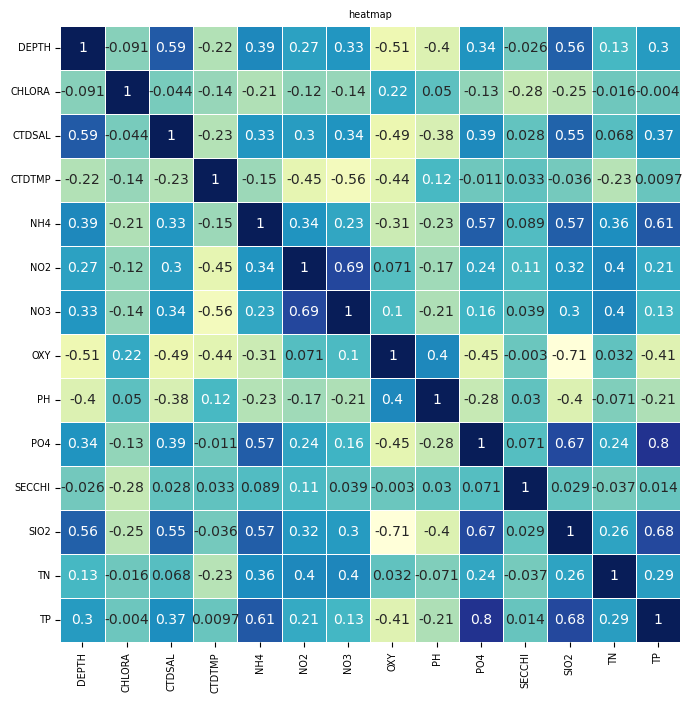

In [1199]:
fig = plt.figure(figsize=(8,8))
sns.heatmap(df.corr(),vmax=1, annot=True, linewidths=0.5, cbar=False, cmap='YlGnBu',annot_kws={'fontsize':10})
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.title('heatmap',fontsize=7)
plt.show()

In [1200]:
# Temperatures measured at the same time are different at different depths
# there are too many values missing before 1986
filtered_df = df[df['DEPTH']==500]
filtered_df = filtered_df[filtered_df['DATE'].dt.year > 1985]
filtered_df = pd.DataFrame(filtered_df)
df_tp = pd.DataFrame()
df_tp['CTDTMP'] = filtered_df['CTDTMP']

In [1201]:
# fill with mean value
# df_tp= df_tp.values.reshape(-1, 1)
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
df_tp = imp_mean.fit_transform(df_tp)
df_tp = pd.DataFrame(df_tp)
df_tp.isnull().sum() # check nan value

0    0
dtype: int64

In [1202]:
# check date colums
def is_valid_date(date_string):
    try:
        pd.to_datetime(date_string)
        return True
    except (ValueError, TypeError):
        return False

In [1203]:
df_tp = df_tp.rename(columns={'0': 'TP'})
df_tp.columns = ['TP']
valid_dates = [date for date in filtered_df['DATE'] if is_valid_date(date)]
df_tp['DATE'] = pd.to_datetime(valid_dates)
df_tp = pd.DataFrame(df_tp)
date_column = df_tp.pop('DATE')
df_tp.insert(0, 'DATE', date_column)  

In [1204]:
df_ = df_tp.copy()

Text(0, 0.5, 'temperature')

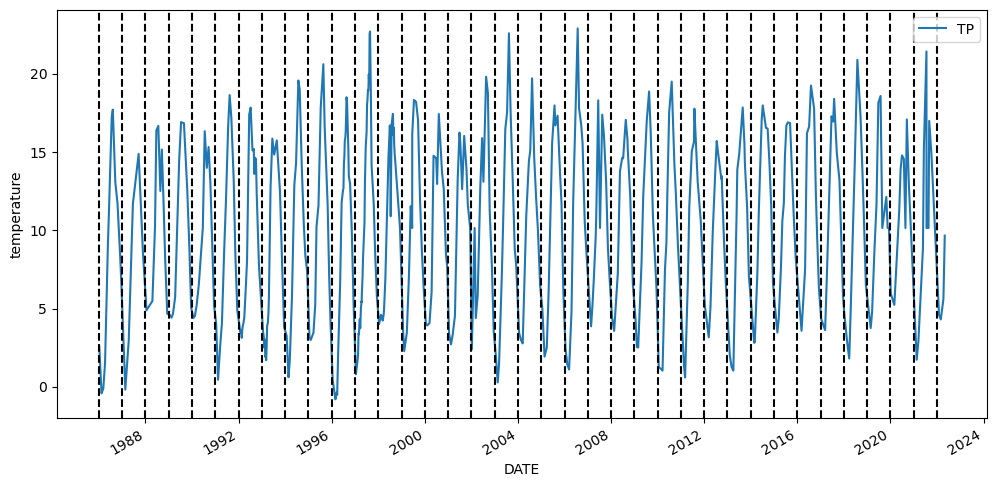

In [1205]:
df_sorted = df_.sort_values('DATE')
start_date = datetime.date(1986, 1, 1)
end_date = datetime.date(2022, 12, 30)

date_list = []
current_date = start_date

while current_date < end_date:
    date_list.append(current_date.strftime('%Y-%m-%d'))
    current_date = current_date.replace(year=current_date.year + 1)
    
ax = df_sorted.plot(x='DATE', y = 'TP', figsize=(12,6))

for xc in date_list:
    plt.axvline(x=xc, color='black', linestyle='--')
ax.set_ylabel('temperature')

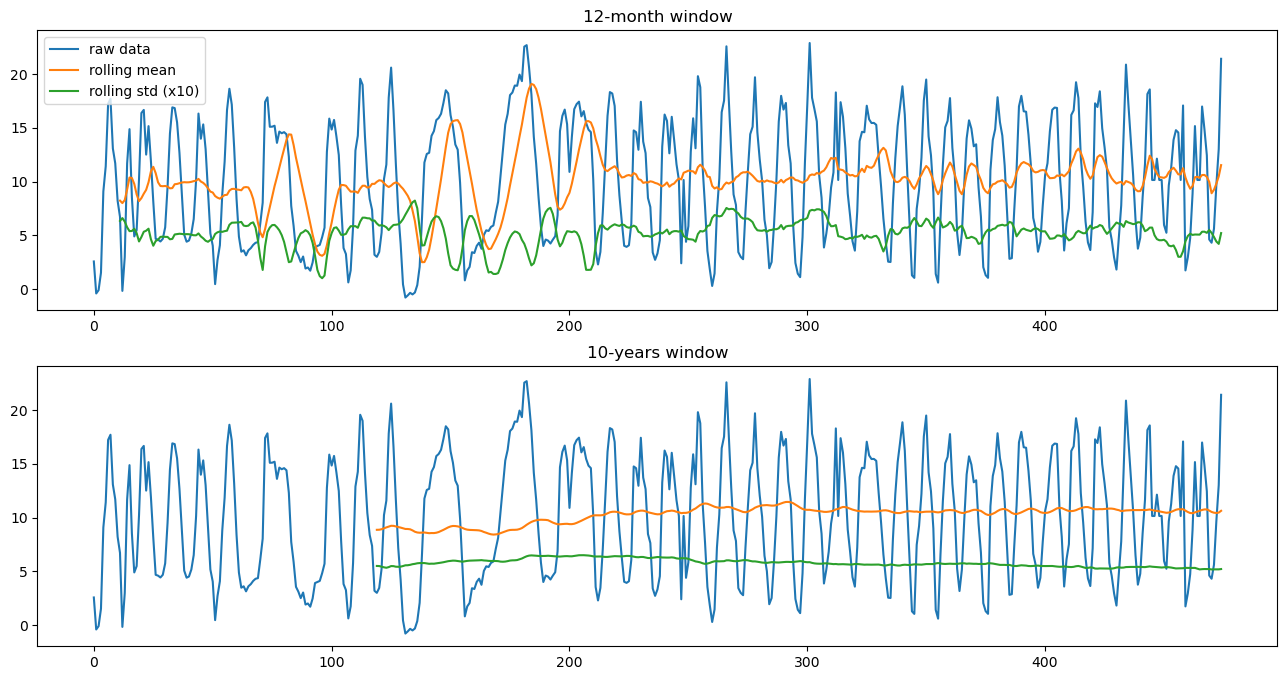

In [1206]:
def analyze_stationarity(timeseries, title):
    fig, ax = plt.subplots(2, 1, figsize=(16, 8))

    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    ax[0].plot(timeseries, label= title)
    ax[0].plot(rolmean, label='rolling mean');
    ax[0].plot(rolstd, label='rolling std (x10)');
    ax[0].set_title('12-month window')
    ax[0].legend()
 
    rolmean = pd.Series(timeseries).rolling(window=120).mean() 
    rolstd = pd.Series(timeseries).rolling(window=120).std()
    ax[1].plot(timeseries, label= title)
    ax[1].plot(rolmean, label='rolling mean');
    ax[1].plot(rolstd, label='rolling std (x10)');
    ax[1].set_title('10-years window')
 
pd.options.display.float_format = '{:.8f}'.format
analyze_stationarity(df_['TP'], 'raw data')

In [1207]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [1208]:
adf_test(df_['TP'])

Results of Dickey-Fuller Test:
Test Statistic                 -7.22841941
p-value                         0.00000000
#Lags Used                     14.00000000
Number of Observations Used   460.00000000
Critical Value (1%)            -3.44464601
Critical Value (5%)            -2.86784368
Critical Value (10%)           -2.57012762
dtype: float64


test statistic is is more negative than critical value, we reject the null hypothesis and conclude that the time serise is stationary.

In [1209]:
def KPSS_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries.dropna(), regression="c", nlags="auto")    
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

KPSS_test(df_['TP'])


Results of KPSS Test:
Test Statistic          0.33806762
p-value                 0.10000000
Lags Used               9.00000000
Critical Value (10%)    0.34700000
Critical Value (5%)     0.46300000
Critical Value (2.5%)   0.57400000
Critical Value (1%)     0.73900000
dtype: float64


p value is above 0.05, we can assume the series is stationary.

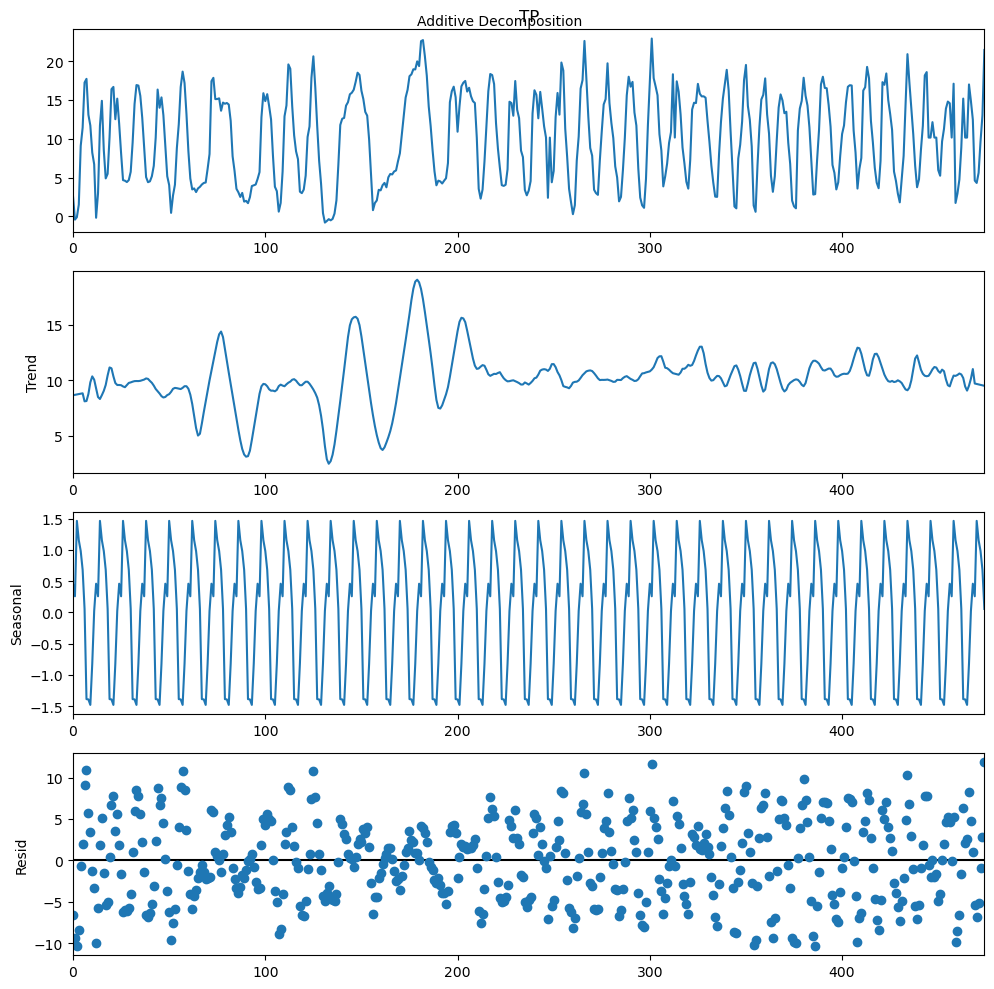

In [1210]:
# Seasonal decomposition
add_result = seasonal_decompose(df_['TP'], model='additive', extrapolate_trend='freq', period=12)

plt.rcParams.update({'figure.figsize':(10,10)})
add_result.plot().suptitle('Additive Decomposition', fontsize=10)
plt.show()

In [1211]:
df_.set_index('DATE',inplace=True)
df_.sort_index()
df_.head(5)

,TP
DATE,
1986-01-07,2.56000000
1986-02-11,-0.42000000
1986-03-11,-0.11000000
1986-04-07,1.51000000
1986-05-22,9.08000000


#  baseline model - moving one step

In [1212]:
predicted_df = df_.shift(1).rename(columns={'TP':'TEMP_pred'})
actual_df = df_.rename(columns={'TP':'TEMP_actual'})

one_step_df = pd.concat([actual_df,predicted_df],axis=1)
one_step_df.sort_index(axis=0)

one_step_df = one_step_df[1:]
one_step_df = one_step_df.sort_index()

temp_pred_error = MSE(one_step_df.TEMP_actual, one_step_df.TEMP_pred)
print('MSE:', temp_pred_error)
print('RMSE:', sqrt(temp_pred_error))


MSE: 12.034428804230886
RMSE: 3.469067425725664


<AxesSubplot:xlabel='DATE'>

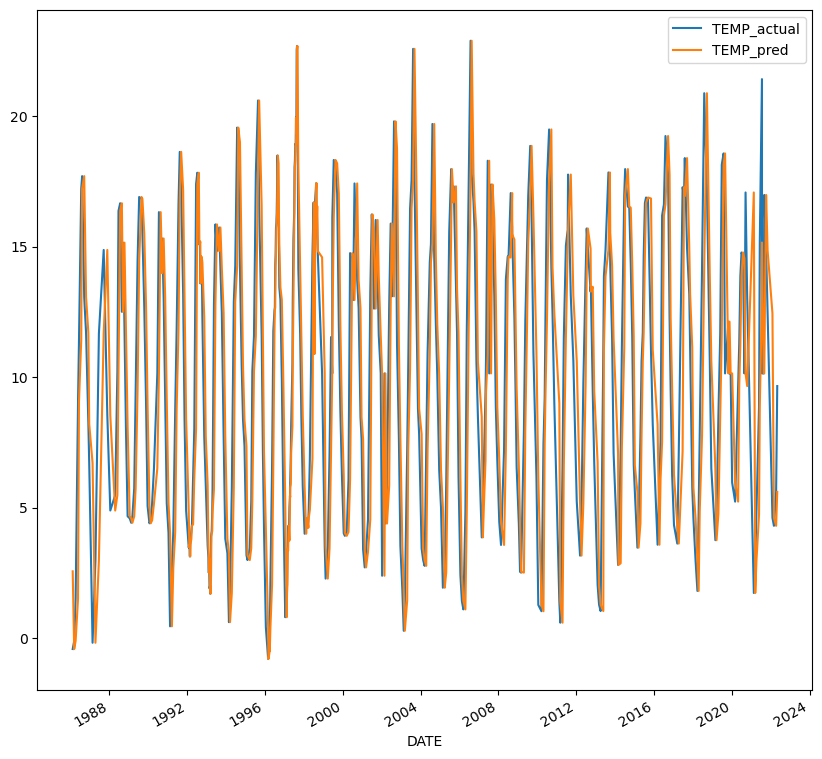

In [1213]:
one_step_df.index = pd.to_datetime(one_step_df.index)
one_step_df.plot()

### SARIMA (Seasonal Autoregressive Integrated Moving Average)

In [1214]:
p = d = q = range(0,2)
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p,d,q))]
# example
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))

SARIMAX: (0, 0, 1) x (0, 0, 1, 7)
SARIMAX: (0, 0, 1) x (0, 1, 0, 7)
SARIMAX: (0, 1, 0) x (0, 1, 1, 7)


In [1215]:
params_list = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(one_step_df.TEMP_actual,
                                            order = param,
                                            seasonal_order = param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
            results = mod.fit(disp = False,full_output=False)
            # print('SARIMA{}x{}7 - AIC:{}'.format(param,param_seasonal,results.aic))
            # case = {'param': param, 'param_seasonal': param_seasonal, 'aic': results.aic}
            # aic_dict.update(case)
            params_list.append([param, param_seasonal, results.aic])
        except:
            continue

In [1216]:
params_list = sorted(params_list, key=lambda x: x[2])[:5]
params_list

[[(1, 0, 1), (1, 1, 1, 7), 2342.933818458624],
 [(1, 0, 1), (0, 1, 1, 7), 2359.3354725753106],
 [(1, 0, 0), (1, 1, 1, 7), 2384.409647658945],
 [(1, 1, 1), (1, 1, 1, 7), 2399.5601130332143],
 [(0, 1, 1), (1, 1, 1, 7), 2400.6266331665597]]

In [1217]:
# fit model
mod1 = sm.tsa.statespace.SARIMAX(one_step_df.TEMP_actual,
                                order=params_list[0][0],
                                seasonal_order=params_list[0][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod1.fit(disp = False)

In [1218]:
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7183      0.043     16.747      0.000       0.634       0.802
ma.L1          0.2987      0.047      6.319      0.000       0.206       0.391
ar.S.L7       -0.2413      0.049     -4.951      0.000      -0.337      -0.146
ma.S.L7       -1.0292      0.035    -29.748      0.000      -1.097      -0.961
sigma2         8.6398      0.750     11.519      0.000       7.170      10.110


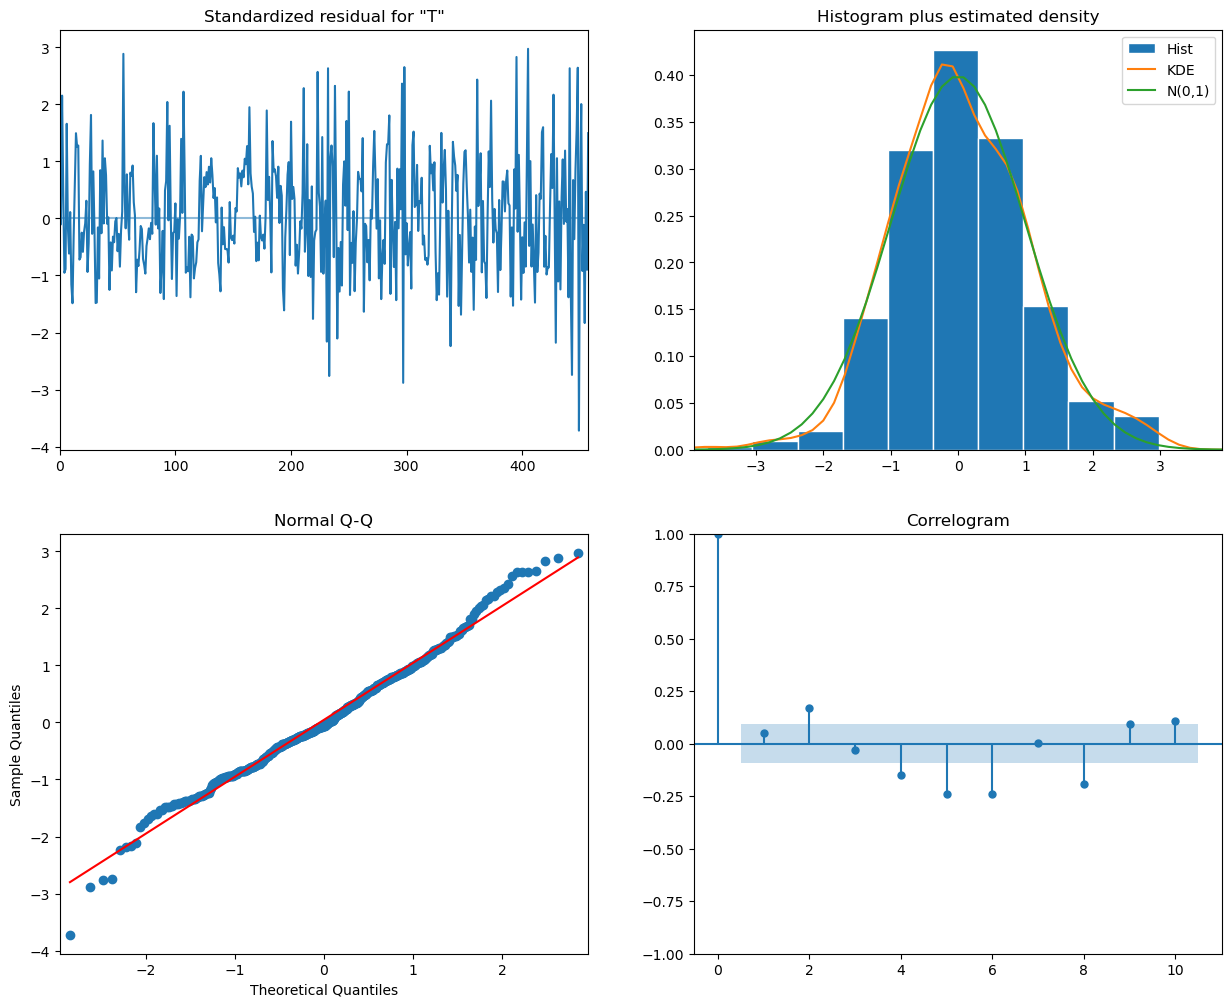

In [1219]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

### validating the forecasts

In [1220]:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)


In [1221]:
pred = results.get_prediction(start=pd.to_datetime('2000-01-18'), dynamic=False)
pred_ci = pred.conf_int()
pred_ci_df = pd.DataFrame(pred_ci)


In [1222]:
pred_df = pd.DataFrame(pred.predicted_mean)

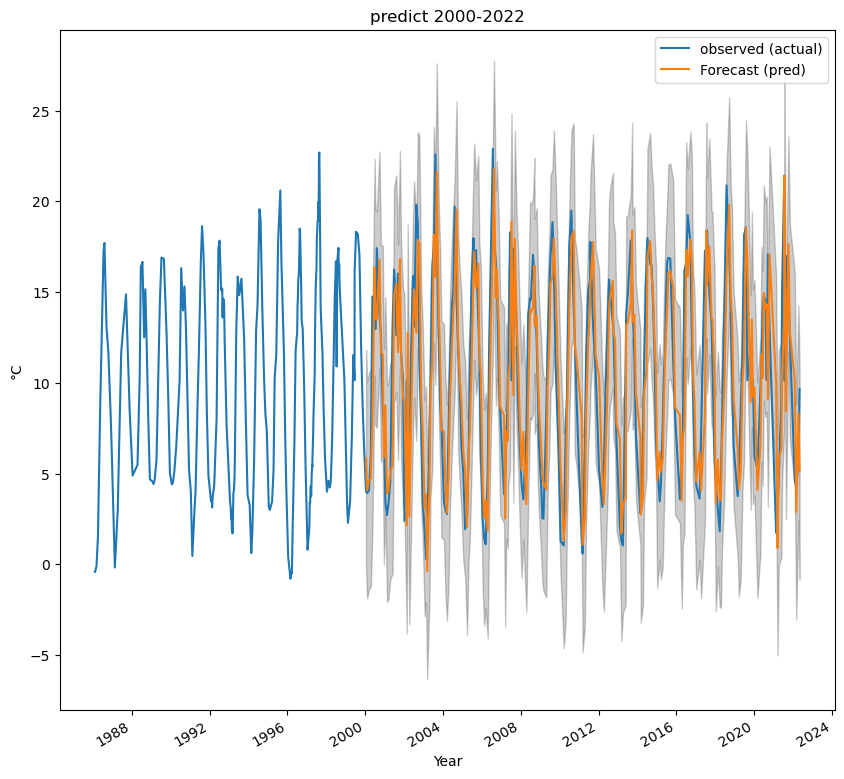

In [1223]:
ax = one_step_df.TEMP_actual['1986':].plot(label='observed (actual)')
pred.predicted_mean.plot(ax=ax, label='Forecast (pred)')

ax.fill_between(pred_ci_df.index,
                pred_ci_df.iloc[:, 0],
                pred_ci_df.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Year')
ax.set_ylabel('°C')
ax.set_title('predict 2000-2022')
plt.legend()
plt.show()

In [1224]:
y_forecasted = pred.predicted_mean
y_truth = one_step_df.TEMP_actual['2000-01-01':]
print(y_forecasted.shape)
print(y_truth.shape)

# RMSE
rmse = sqrt(MSE(y_truth, y_forecasted).mean())
print('RMSE: {}'.format(round(rmse, 2)))

(251,)
(251,)
RMSE: 3.4


### predict temp in 2022 - 2025

In [1225]:
# 3 years * 12 month + 1 month(2022 Dec)
pred_uc = results.get_forecast(steps=37, dynamic=False)
pred_ci = pred_uc.conf_int()

In [1226]:
date_range = pd.date_range(start='2021-12-01', end='2024-12-31', freq='M')
df_pred_ci = pd.DataFrame(pred_ci)
df_pred_ci = df_pred_ci.set_index(date_range)

In [1227]:
date_range = pd.date_range(start='2021-12-01', end='2024-12-31', freq='M')
df_pred_uc = pd.DataFrame(pred_uc.predicted_mean)
df_pred_uc = df_pred_uc.set_index(date_range)

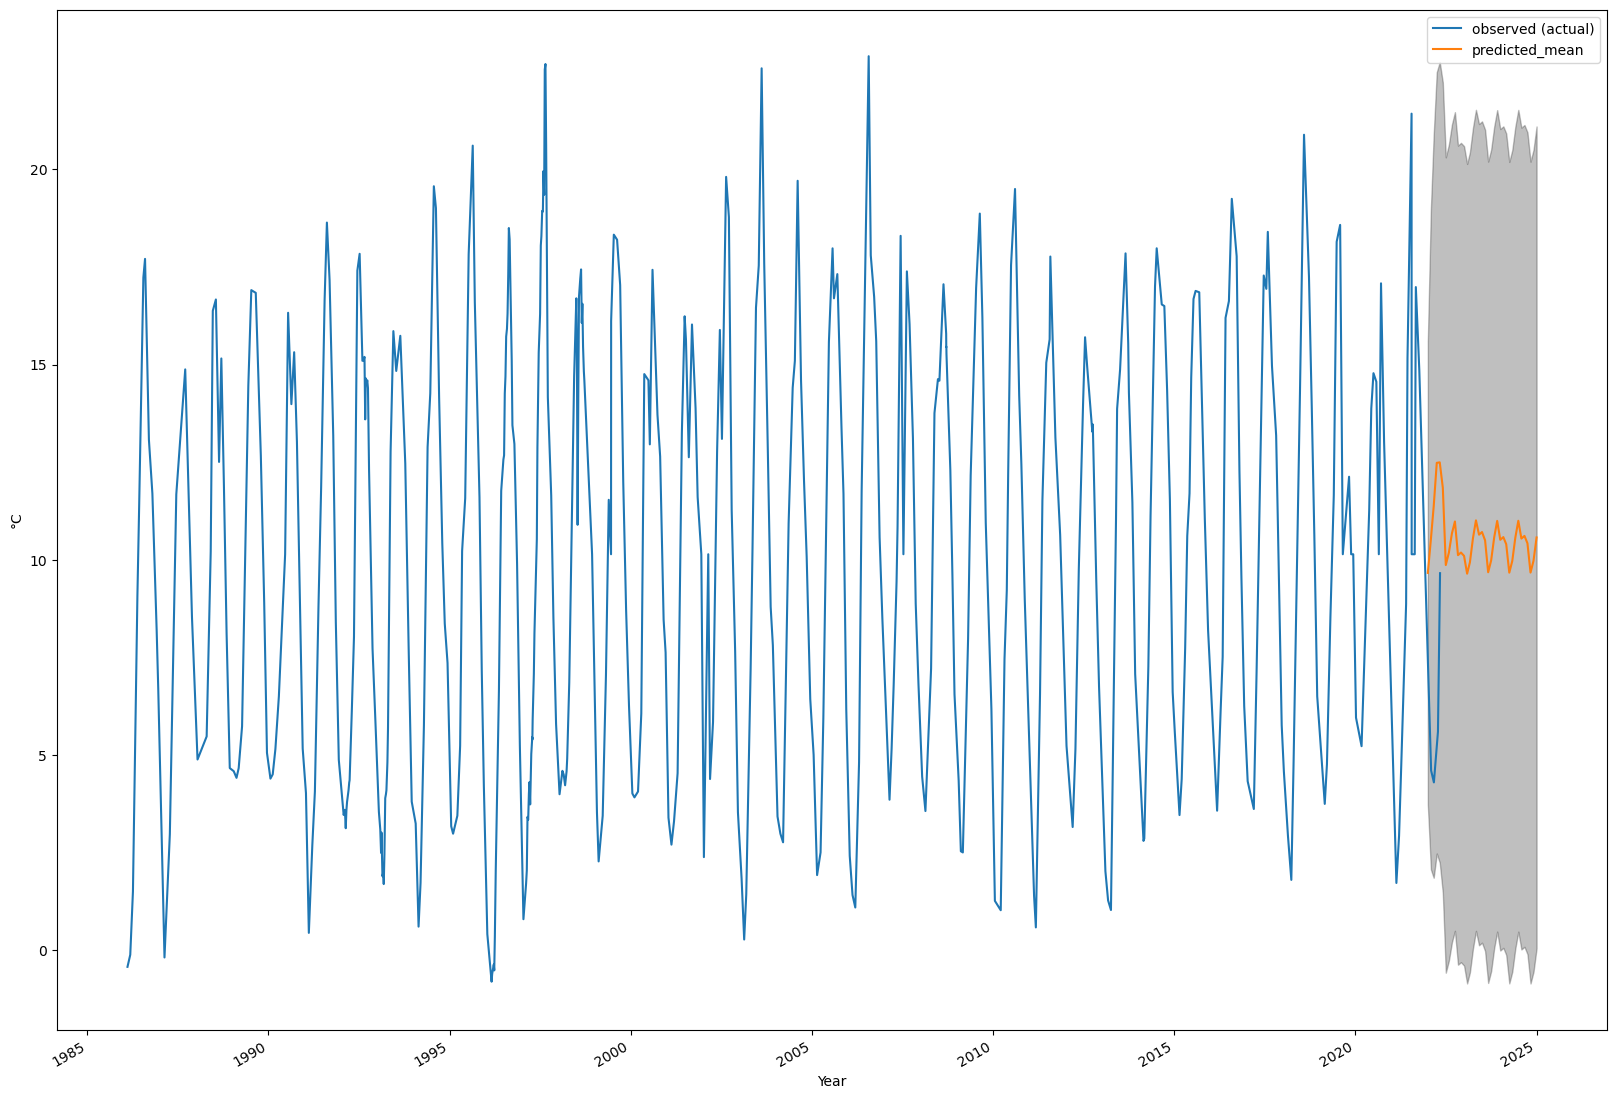

In [1228]:
ax = one_step_df.TEMP_actual.plot(label='observed (actual)',figsize=(20, 15))
# df_pred_uc.plot(label='Forecast（pred）', ax=ax)
df_pred_uc.plot(label='Forecast（pred）', ax=ax)
ax.fill_between(df_pred_ci.index,
                df_pred_ci.iloc[:, 0],
                df_pred_ci.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Year')
ax.set_ylabel('°C')

plt.legend()
plt.show()